In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time
import wandb
import torch
import random
import pickle
import imageio
import librosa
import torchaudio
import torchvision

import numpy as np
import pandas as pd
import torchmetrics as tm 
import plotly.express as px
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from torch import nn
from pathlib import Path
from IPython.display import Audio
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, AdamW, RMSprop # optmizers
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau # Learning rate schedulers

import albumentations as A
# from albumentations.pytorch import ToTensorV2

import timm

In [3]:
print('timm version', timm.__version__)
print('torch version', torch.__version__)

timm version 0.9.16
torch version 2.3.0


In [4]:
# detect and define device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [5]:
train_dir = Path('E:\data\BirdCLEF')

class CFG:
    DEBUG = False # True False

    USE_MISSING_LABELS = False

    # Competition Root Folder
    ROOT_FOLDER = train_dir
    AUDIO_FOLDER = train_dir / 'train_audio'
    UNLABELED_FOLDER = train_dir / 'unlabeled_soundscapes'
    DATA_DIR = train_dir / 'spectros'
    TRAN_CSV = train_dir / 'train_metadata.csv'
    RESULTS_DIR = train_dir / 'results'
    CKPT_DIR = train_dir / 'ckpt'

    num_workers = 8
    # Maximum decibel to clip audio to
    TOP_DB = 100
    # Minimum rating
    MIN_RATING = 3.0
    # Sample rate as provided in competition description
    SR = 32000

    image_size = 128
    
    ### split train and validation sets
    split_fraction = 0.95
    
    ### model
    model_name = 'eca_nfnet_l0' # 'resnet34', 'resnet200d', 'efficientnet_b1_pruned', 'efficientnetv2_m', efficientnet_b7 ...  
    
    ### training
    BATCH_SIZE = 4
    # N_EPOCHS = 3 if DEBUG else 40
    N_EPOCHS = 20
    LEARNING_RATE = 5*1e-6
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    random_seed = 42
    comment = 'first'

mel_spec_params = {
    "sample_rate": CFG.SR,
    "n_mels": 128,
    "f_min": 20,
    "f_max": CFG.SR / 2,
    "n_fft": 2048,
    "hop_length": 512,
    "normalized": True,
    "center" : True,
    "pad_mode" : "constant",
    "norm" : "slaney",
    "mel_scale" : "slaney"
}

CFG.mel_spec_params = mel_spec_params

sec_labels = ['lotshr1', 'orhthr1', 'magrob', 'indwhe1', 'bltmun1', 'asfblu1']

sample_submission = pd.read_csv(train_dir / 'sample_submission.csv')

# Set labels
CFG.LABELS = sample_submission.columns[1:].tolist()
if CFG.USE_MISSING_LABELS:
    CFG.LABELS += sec_labels
    
CFG.N_LABELS = len(CFG.LABELS)
print(f'# labels: {CFG.N_LABELS}')

display(sample_submission.head())

# labels: 182


,row_id,asbfly,ashdro1,ashpri1,ashwoo2,asikoe2,asiope1,aspfly1,aspswi1,barfly1,...,whbwoo2,whcbar1,whiter2,whrmun,whtkin2,woosan,wynlau1,yebbab1,yebbul3,zitcis1
0,soundscape_1446779_5,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,...,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495
1,soundscape_1446779_10,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,...,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495
2,soundscape_1446779_15,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,...,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495


In [6]:
# for reproducibility
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed = CFG.random_seed)

### Prepare dataframe

In [7]:
files = [f for f in sorted(os.listdir(CFG.UNLABELED_FOLDER))]
len(files)

8444

In [8]:
file_path = CFG.UNLABELED_FOLDER / files[0]
data, rate = torchaudio.load(file_path)
print("Audio data shape:", data.shape)
print("Sample rate:", rate)

Audio data shape: torch.Size([1, 7680000])
Sample rate: 32000


In [9]:
step = 5
ranges = np.arange(0+step, 240+step, step)
ranges

array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
        70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130,
       135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195,
       200, 205, 210, 215, 220, 225, 230, 235, 240])

In [10]:
results_df = pd.DataFrame(files, columns = ['file'])
results_df['range'] = [ranges] * len(results_df)
# results_df.reset_index(drop=True, inplace=True)
results_df = results_df.explode('range', ignore_index=True)
# results_df.reset_index(drop=True, inplace=True)

In [11]:
pd.set_option('max_colwidth', 40)

In [12]:
results_df.head()

,file,range
0,1000170626.ogg,5
1,1000170626.ogg,10
2,1000170626.ogg,15
3,1000170626.ogg,20
4,1000170626.ogg,25


### Prepare dataset

In [13]:
from dataset import bird_dataset_inference, read_wav

In [14]:
files = [f for f in sorted(os.listdir(CFG.UNLABELED_FOLDER))]
len(files)

8444

In [15]:
files[0]

'1000170626.ogg'

In [16]:
dset = bird_dataset_inference(files, CFG.UNLABELED_FOLDER, CFG)
len(dset)

8444

In [17]:
spect, filename = dset.__getitem__(0)

spect.dtype, spect.shape, filename

(torch.float32, torch.Size([48, 3, 128, 128]), '1000170626.ogg')

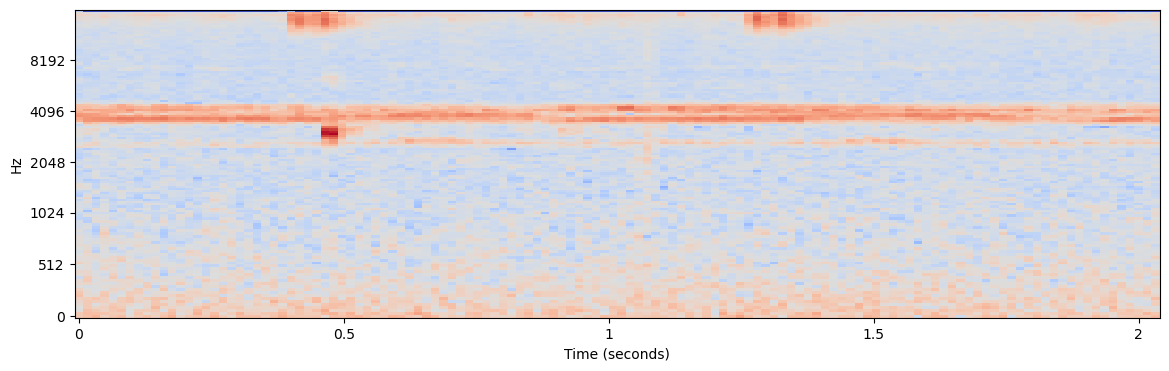

In [18]:
plt.figure(figsize=(14, 4))
librosa.display.specshow(spect[0,0].numpy(), y_axis="mel", x_axis='s', sr=CFG.SR)
plt.show()

In [19]:
spect = spect[0]
spect.shape

torch.Size([3, 128, 128])

In [20]:
remainder = spect.shape[-1] % 48
spect.shape[-1] % 48, spect.shape[-1] // 48

(32, 2)

In [21]:
splits = torch.split(spect[:,:,:-remainder], 312, dim=-1)
len(splits), splits[0].shape, splits[-1].shape

(1, torch.Size([3, 128, 96]), torch.Size([3, 128, 96]))

In [22]:
splits = torch.stack(splits)
splits.shape

torch.Size([1, 3, 128, 96])

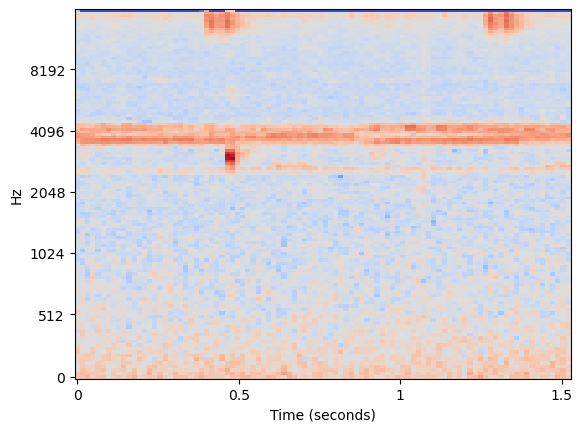

In [23]:
librosa.display.specshow(splits[0,0].numpy(), y_axis="mel", x_axis='s', sr=CFG.SR)
plt.show()

### Dataloader

In [24]:
from dataset import bird_dataset_inference

In [25]:
def collate_fn(batch):
   return  torch.stack([x[0] for x in batch]), torch.stack([x[1] for x in batch])

In [26]:
class inference_datamodule(pl.LightningDataModule):
    def __init__(self, files, directory, cfg=CFG, tfs=None, resize_tf=None):
        super().__init__()
        
        self.files = files
        self.dir = directory

        self.tfs = tfs
        self.resize_tf = resize_tf

        self.cfg = cfg

        self.bs = self.cfg.BATCH_SIZE
        self.num_workers = cfg.num_workers
        
    def predict_dataloader(self):
        ds = bird_dataset_inference(self.files, self.dir, self.cfg)
        
        train_loader = torch.utils.data.DataLoader(
            ds,
            batch_size=self.bs,
            pin_memory=False,
            drop_last=False,
            # shuffle=True,
            # collate_fn=collate_fn,
            persistent_workers=True,
            num_workers=self.num_workers,
        )
        
        return train_loader

In [27]:
dm = inference_datamodule(files, CFG.UNLABELED_FOLDER)

In [28]:
x, filenames = next(iter(dm.predict_dataloader()))
x.shape, x.dtype

(torch.Size([4, 48, 3, 128, 128]), torch.float32)

In [29]:
torch.flatten(x, start_dim=0, end_dim=1).shape

torch.Size([192, 3, 128, 128])

In [30]:
filenames

('1000170626.ogg', '1000308629.ogg', '1000389428.ogg', '1000424265.ogg')

### Load model

In [53]:
class GeM(torch.nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = torch.nn.Parameter(torch.ones(1) * p)
        self.eps = eps

    def forward(self, x):
        bs, ch, h, w = x.shape
        x = torch.nn.functional.avg_pool2d(x.clamp(min=self.eps).pow(self.p), (x.size(-2), x.size(-1))).pow(
            1.0 / self.p)
        x = x.view(bs, ch)
        return x

class GeMModel(pl.LightningModule):
    def __init__(self, cfg = CFG, pretrained = True):
        super().__init__()

        self.cfg = cfg
        
        out_indices = (3, 4)

        print(self.cfg.model_name)
        
        self.backbone = timm.create_model(
            self.cfg.model_name, 
            features_only=True,
            pretrained=False,
            in_chans=3,
            num_classes=self.cfg.N_LABELS,
            out_indices=out_indices,
        )

        feature_dims = self.backbone.feature_info.channels()

        self.global_pools = torch.nn.ModuleList([GeM() for _ in out_indices])
        self.mid_features = np.sum(feature_dims)
        
        self.neck = torch.nn.BatchNorm1d(self.mid_features)
        self.head = torch.nn.Linear(self.mid_features, self.cfg.N_LABELS)

    def forward(self, x):
        ms = self.backbone(x)
        
        h = torch.cat([global_pool(m) for m, global_pool in zip(ms, self.global_pools)], dim=1)
        x = self.neck(h)
        x = self.head(x)
        
        return x

    def predict_step(self, batch):
        spects, files = batch
        spects = torch.flatten(spects, start_dim=0, end_dim=1)

        preds = self(spects)

        results_df = pd.DataFrame(files, columns = ['file'])
        results_df['range'] = [ranges] * len(results_df)
        results_df = results_df.explode('range', ignore_index=True)
        results_df['row_id'] = results_df.apply(lambda row: row['file'] + '_' + str(row['range']), axis=1)

        topk = preds.sigmoid().topk(3, dim=-1)
        
        vals = topk[0].cpu().detach().numpy()
        idx = topk[1].cpu().detach().numpy()

        cols = [f'top_{k+1}' for k in range(3)] + [f'top_{k+1}_idx' for k in range(3)]
        vals_df = pd.DataFrame(vals, columns=cols[:3])
        idx_df = pd.DataFrame(idx, columns=cols[3:])
        
        # results = torch.cat(results[0].tolist(), results[1].tolist())

        
        # preds_df = pd.DataFrame(results, columns=cols)

        results_df = pd.concat([results_df, vals_df, idx_df], axis=1)
        
        # return results_df, preds
        return results_df

In [54]:
# model_path = Path("E:\\data\\BirdCLEF\\results\\Bird-local\\g5aw82o5\\checkpoints")
model_path = Path("E:\\data\\BirdCLEF\\results\\ckpt\\eca_nfnet_l0 5e-05 30 eps mixup-plain\\ep_29_acc_0.60490.ckpt")

# model_path = model_path / os.listdir(model_path)[0]
model_path

WindowsPath('E:/data/BirdCLEF/results/ckpt/eca_nfnet_l0 5e-05 30 eps mixup-plain/ep_29_acc_0.60490.ckpt')

In [55]:
([f'top_{k+1}' for k in range(3)] + [f'top_{k+1}_idx' for k in range(3)])

['top_1', 'top_2', 'top_3', 'top_1_idx', 'top_2_idx', 'top_3_idx']

In [56]:
model = GeMModel.load_from_checkpoint(model_path)

eca_nfnet_l0


### Predict

In [57]:
files = [f for f in sorted(os.listdir(CFG.UNLABELED_FOLDER))]
len(files)

8444

In [58]:
files[0]

'1000170626.ogg'

In [59]:
# dm = inference_datamodule(files[:10], CFG.UNLABELED_FOLDER)
dm = inference_datamodule(files, CFG.UNLABELED_FOLDER)

In [60]:
trainer = pl.Trainer()
predictions = trainer.predict(model, dataloaders=dm)
len(predictions)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                             | 0/? [00:00<?, ?it/…

2111

In [38]:
# data = predictions[0][1]
# data.shape

In [39]:
# data_df = pd.DataFrame(data.softmax(dim=-1).numpy(), columns=CFG.LABELS)
# data_df.head()

In [61]:
len(predictions)

2111

In [62]:
predictions = pd.concat(predictions, ignore_index=True)
predictions.shape

(405312, 9)

In [63]:
predictions.shape

(405312, 9)

In [78]:
predictions.sample(5)

,filename,range,top_1,top_2,top_3,top_1_idx,top_2_idx,top_3_idx
222678,E:\data\BirdCLEF\unlabeled_soundscap...,35,0.081711,0.045561,0.037761,142,10,50
272846,E:\data\BirdCLEF\unlabeled_soundscap...,75,0.203893,0.041404,0.034239,10,149,73
228668,E:\data\BirdCLEF\unlabeled_soundscap...,225,0.214347,0.209631,0.031574,136,24,38
357816,E:\data\BirdCLEF\unlabeled_soundscap...,125,0.360511,0.268081,0.070570,30,10,69
251869,E:\data\BirdCLEF\unlabeled_soundscap...,70,0.195408,0.073489,0.057515,73,67,177


In [67]:
predictions[predictions['top_1'] > 0.9].shape

(10366, 9)

In [86]:
predictions[predictions['top_1'] < 0.2].shape

(155241, 8)

In [87]:
predictions[predictions['top_1'] < 0.1].sample(4)

,filename,range,top_1,top_2,top_3,top_1_idx,top_2_idx,top_3_idx
87173,E:\data\BirdCLEF\unlabeled_soundscap...,30,0.088910,0.071029,0.048530,30,73,155
204278,E:\data\BirdCLEF\unlabeled_soundscap...,195,0.046671,0.036199,0.029810,10,51,1
131884,E:\data\BirdCLEF\unlabeled_soundscap...,145,0.085949,0.039331,0.037648,44,73,30
398853,E:\data\BirdCLEF\unlabeled_soundscap...,110,0.061466,0.059454,0.038423,73,177,1


In [44]:
# predictions['row_id'] = predictions.apply(lambda row: row['file'] + '_' + str(row['range']), axis=1)

In [45]:
# predictions[predictions['score'] > 0.95].shape

In [ ]:
# predictions['score'].hist()

### Save

In [69]:
predictions.drop('row_id', axis=1, inplace=True)

In [72]:
predictions.rename(columns={'file': 'filename'}, inplace=True)

In [76]:
predictions['filename']  = f'{CFG.UNLABELED_FOLDER}\\' + predictions['filename']

In [77]:
predictions.to_csv(train_dir / "predictions.csv", index=False)